In [1]:
import sys
sys.path.insert(1, r"/vol/bitbucket/mjh24/IAEA-thesis")
import os
os.environ.setdefault("HF_HOME", "/data/mjh24/hf")
os.environ.setdefault("TRANSFORMERS_CACHE", "/data/mjh24/hf/transformers")
os.makedirs(os.environ["TRANSFORMERS_CACHE"], exist_ok=True)
from Stage1.GAT.GATModel import GraphAttentionNetwork
from Single_Website_Download.Download import main as downloadHTML
import torch
from Stage1.ExtractingGraphs.seleniumDriver import *
from Stage2.txtGraphExtraction.extract_mini_txt_graphs_helper import *
from Stage2.txtGraphExtraction.extract_mini_txt_graphs_helper import main as txtExtractor
from Stage1.tree_helpers import *
from Stage2.txtGraphPruning.display_txt_graph import draw_graph_from_arrays
from Stage2.txtGraphPruning.prune_txt_graph import main as prune_txt_graph
from Stage2.classifyingEdges.classifyingTextNodes import clean_instructional_text, classify_link_pairs_flan_batched
from Stage2.classifyingEdges.classifyingAnEdgeFLANT5 import classify_link_pairs_zero_shot
from Stage2.classifyingEdges.classifyingAnEdgeOpenAI import classify_link_pairs_openAI
from Stage2.classifyingEdges.metrics import metrics
#from Stage2.classifyingEdges.classifyingAnEdgeOpenAI import classify_link_pairs_openAI
from pathlib import Path
import numpy as np

CLIP_TO_N_EDGES_PER_NODE = 10 # This is to clip all the outgoing edges per node to a certain number
device = device or ("cuda" if torch.cuda.is_available() else "cpu")
REMOVE_DUPES = False

/vol/bitbucket/mjh24/IAEA-thesis/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/vol/bitbucket/mjh24/IAEA-thesis/.venv/lib/python3.12/site-packages/transformers/utils/hub.py:111: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [2]:
# Load model
model = GraphAttentionNetwork(in_dim = 119, edge_in_dim = 210, edge_emb_dim = 32, hidden1 = 32, hidden2 = 32, hidden3 = 8, heads = 2)
state_dict = torch.load("/vol/bitbucket/mjh24/IAEA-thesis/Stage1/GAT/LONG80EPOCH-75f1-newlabelnotitle.pt", map_location=torch.device(device))
model.load_state_dict(state_dict, strict=False)
model.to(device)

# Load the website
# url = "/vol/bitbucket/mjh24/IAEA-thesis/data/swde/sourceCode/sourceCode/movie/movie/movie-allmovie(2000)/0000.htm"
# url = r"https://www.nucnet.org/news/parliament-resolution-paves-way-for-establishing-nuclear-energy-legislation-6-4-2024"
url = "https://westinghousenuclear.com/"
# url = "https://www.football.co.uk/news/leeds-vs-bournemouth-premier-league-team-news-lineups-prediction/781112/"
# url = r"https://www.bbc.co.uk/news/live/cev28rvzlv1t"
# url = "https://www.nfl.com/teams/" # Great to show teams and structured data
# url = "https://www.energy.gov/ne/articles/advantages-and-challenges-nuclear-energy" #Great to show semi structured webpages with titles
# url = "https://westinghousenuclear.com/nuclear-fuel/fuel-fabrication-operations/"
# url = "https://www.livescore.com/en/football/england/premier-league/bournemouth-vs-leicester-city/1250940/lineups/"
htmlFile = Path("/vol/bitbucket/mjh24/IAEA-thesis/data/websites/test.html")
downloadHTML(url,1,htmlFile)

Saved https://westinghousenuclear.com/ → /vol/bitbucket/mjh24/IAEA-thesis/data/websites/test.html
Page limit hit


In [3]:
# Get label edges from text nodes in the website
sorted_label_index_extracted, xpaths_extracted, txts_extracted, probs_extracted = txtExtractor(htmlFile, model, remove_dupes=REMOVE_DUPES)
model.to("cpu")         # offload to CPU
if torch.cuda.is_available():
    torch.cuda.empty_cache() # reclaim GPU cache

/vol/bitbucket/mjh24/IAEA-thesis/Stage2/txtGraphExtraction/extract_mini_txt_graphs_helper.py:141: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /pytorch/aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  return torch.sparse_csr_tensor(


In [4]:
# Normalise the text
normtxt = []
for a, b in txts_extracted:
    normtxt.append([normalise_text(a, "%'\\s"), normalise_text(b, "%'\\s")])
txts, probs, sorted_label_index, xpaths = np.array(normtxt), np.array(probs_extracted), np.array(sorted_label_index_extracted), np.array(xpaths_extracted)

In [5]:
# Remove all html instructional labels
txtsShortened = [[a.split(".")[0], b.split(".")[0]] for a, b in txts]
isInstruction, instructionalTxt = clean_instructional_text(txtsShortened, batch_size=32)
opmask = np.array(isInstruction, dtype=bool)
mask = np.logical_not(opmask)

for key, value in instructionalTxt.items():
    if value == 1:
        print(key)

learn more watch video
blog
learn more about why databricks selected westinghouse ai for its 2025 data intelligence in energy utility award
explore careers
access our custom technology library designed for nuclear engineering students and professionals
explore
explore our interactive 3d visualization tool for innovative answers to operating plant challenges
x click on the background to close the video
explore now
take a look
learn more
france french
read more
join our team
learn more about how westinghouse enhances training staffing and outsourcing with options that benefit your plants bottom line


In [6]:
txts, probs, sorted_label_index, xpaths = txts[mask], probs[mask], sorted_label_index[mask], xpaths[mask]

In [7]:
# -- RUN THE MAIN PRUNING MASK --
mask = prune_txt_graph(probs, sorted_label_index, toloerance=0.01, remove_dupes=REMOVE_DUPES)

# Concatanate and apply masks if we want specific text
mask = mask 
print(len(sorted_label_index), " -> ", len(sorted_label_index[mask]))
txts, probs, sorted_label_index, xpaths = txts[mask], probs[mask], sorted_label_index[mask], xpaths[mask]
# -- PRUNING FINISHED --

2256  ->  127


In [9]:
# Classify the edges
classificationDeBerta, scoresDeberta = classify_link_pairs_zero_shot(txts, batch_size=64, confidence_Factor=0.9, return_scores=True)
classificationFlan = classify_link_pairs_flan_batched(txts, batch_size=64)
classificationOpenAI = classify_link_pairs_openAI(txts[:41])


Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['output_scores']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_scores']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Expected total price: $0.0061323

Batch 1 (pairs 0..40): ~input tokens=1,990, ~output tokens=82, est. cost=$0.0061 (IN=$0.05/1M, OUT=$0.4/1M)
Total_tokens= 5921  {input_tokens= 1996  reasoning_tokens= 3840  output_tokens= 85 }
Running Total cost: $ 0.0016698  This batch cost: $ 0.0016698


ValueError: Expected 41 labels for batch 1, got 40 (soft 40). Raw output:
1 1 1 1 1 1 1 1 3 3 1 1 3 3 3 3 1 1 1 1 1 1 1 1 3 3 3 3 1 1 1 1 3 3 1 1 3 3 3 1

In [ ]:
y_true_str = "2 2 1 1 ? ? ? ? 3 3 1 1 3 3 2 2 2 2 1 1 ? ? 1 1 3 3 1 1 3 3 1 1 1 1 2 2 2 2 2 2"
classificationOpenAI = [1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 1, 1, 1, 1, 3, 3, 1, 1, 3, 3, 3, 1]
y_true = [3 if tok == "?" else int(tok) for tok in y_true_str.split()]

Samples: 40
Classes: [1, 2, 3]

Accuracy: 0.45
Balanced Accuracy: 0.4603174603174603

Confusion Matrix (rows=true, cols=pred):
 [[10  4  0]
 [ 4  8  0]
 [14  0  0]]

Confusion Matrix (normalized by true class):
 [[0.714 0.286 0.   ]
 [0.333 0.667 0.   ]
 [1.    0.    0.   ]]

Per-class metrics (order: class 1, 2, 3)
 Class 1: precision=0.3571  recall=0.7143  f1=0.4762  support=14
 Class 2: precision=0.6667  recall=0.6667  f1=0.6667  support=12
 Class 3: precision=0.0000  recall=0.0000  f1=0.0000  support=14

Averaged metrics:
 Macro   -> precision=0.3413  recall=0.4603  f1=0.3810
 Micro   -> precision=0.4500  recall=0.4500  f1=0.4500
 Weighted -> precision=0.3250  recall=0.4500  f1=0.3667

Cohen's kappa: 0.1729323308270676
Matthews corrcoef (MCC): 0.21760174437497148

Classification report:

              precision    recall  f1-score   support

           1     0.3571    0.7143    0.4762        14
           2     0.6667    0.6667    0.6667        12
           3     0.0000    0.0000 

In [ ]:
metrics(classificationDeBerta[:len(y_true)], y_true)
metrics(classificationFlan[:len(y_true)], y_true)
metrics(classificationOpenAI[:len(y_true)], y_true)

In [ ]:
if len(classificationDeBerta) != len(txts):
    raise Exception("The classification is not the same length as the number of edges")
for (pair, lab, sc) in zip(txts, classificationDeBerta, scoresDeberta or []):
        print(lab, pair, "| scores:", {k: round(v, 3) for k, v in sc.items()})

2 ['ap300 smr'
 'the ap300 smr is the next evolution of the licensed ap1000 technology'] | scores: {1: 0.62, 2: 0.646, 3: 0.089}
2 ['the ap300 smr is the next evolution of the licensed ap1000 technology'
 'ap300 smr'] | scores: {1: 0.62, 2: 0.646, 3: 0.089}
1 ['enhance your training staffing and outsourcing needs with our training and resource solutions'
 'westinghousenavigator'] | scores: {1: 0.695, 2: 0.63, 3: 0.008}
1 ['westinghousenavigator'
 'enhance your training staffing and outsourcing needs with our training and resource solutions'] | scores: {1: 0.695, 2: 0.63, 3: 0.008}
1 ['evinci microreactor'
 'the next generation small modular reactor for remote applications'] | scores: {1: 0.539, 2: 0.524, 3: 0.085}
1 ['the next generation small modular reactor for remote applications'
 'evinci microreactor'] | scores: {1: 0.539, 2: 0.524, 3: 0.085}
1 ['enhance your training staffing and outsourcing needs with our training and resource solutions'
 'westinghouseiq'] | scores: {1: 0.722, 2

['ap300 smr'
 'the ap300 smr is the next evolution of the licensed ap1000 technology']
['the ap300 smr is the next evolution of the licensed ap1000 technology'
 'ap300 smr']
['evinci microreactor'
 'the next generation small modular reactor for remote applications']
['the next generation small modular reactor for remote applications'
 'evinci microreactor']
['enhance your training staffing and outsourcing needs with our training and resource solutions'
 'westinghousenavigator']
['westinghousenavigator'
 'enhance your training staffing and outsourcing needs with our training and resource solutions']
['enhance your training staffing and outsourcing needs with our training and resource solutions'
 'westinghouseiq']
['westinghouseiq'
 'enhance your training staffing and outsourcing needs with our training and resource solutions']
['when it comes to creating a more sustainable planet the need for renewable energy cant replace the need for safe energy with nuclear power you get the best of b

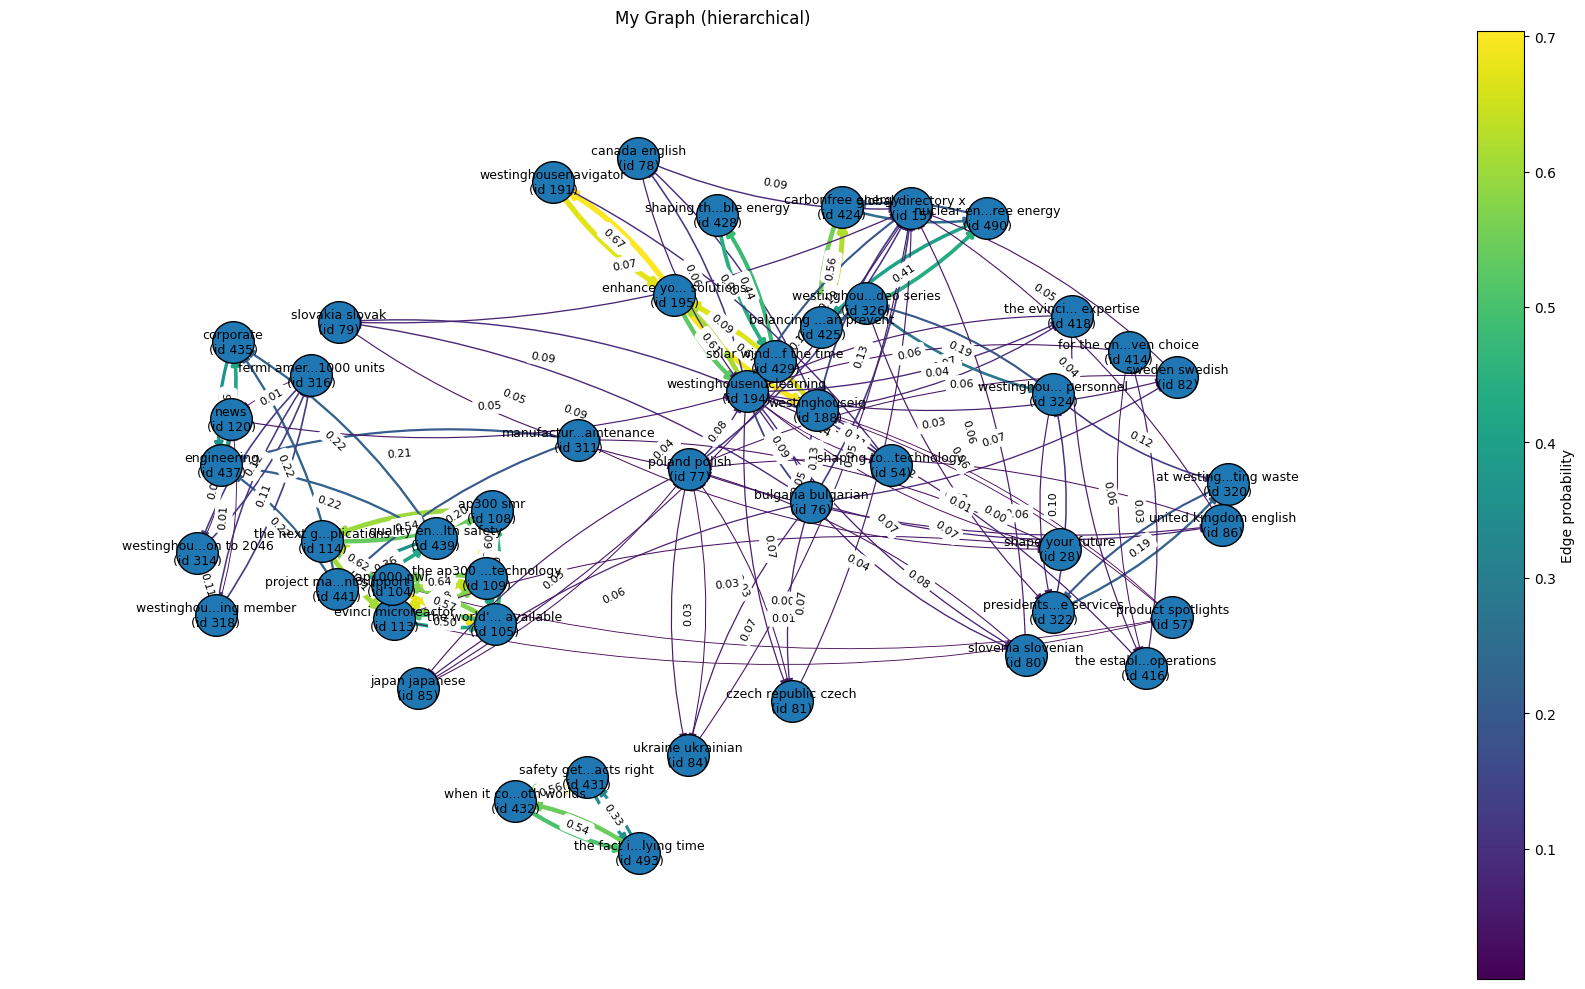

{'G': <networkx.classes.digraph.DiGraph at 0x79ab30b8cf80>,
 'pos': {108: array([-0.36796381, -0.08788311]),
  109: array([-0.3771159 , -0.26766893]),
  113: array([-0.54343404, -0.37512754]),
  114: array([-0.6730182, -0.1668393]),
  195: array([-0.03914329,  0.48954218]),
  191: array([-0.25721228,  0.79126407]),
  188: array([0.21908099, 0.18098959]),
  432: array([-0.32550484, -0.86275613]),
  431: array([-0.19650969, -0.79817822]),
  104: array([-0.54731364, -0.2821303 ]),
  105: array([-0.36159996, -0.38968989]),
  425: array([0.2260291 , 0.40301081]),
  424: array([0.26275056, 0.72364456]),
  194: array([0.0916044 , 0.23152773]),
  493: array([-0.10223383, -1.        ]),
  429: array([0.14267989, 0.31222892]),
  428: array([0.03871737, 0.70370812]),
  490: array([0.52489128, 0.69449356]),
  441: array([-0.64710291, -0.29501648]),
  439: array([-0.46860053, -0.16124707]),
  437: array([-0.85476462,  0.03437232]),
  435: array([-0.83364417,  0.36379591]),
  326: array([0.30640687,

In [ ]:
# Display the graph
textmask = np.array([True]*len(txts))
#textmask = filterTextMask(txts, "%", False) #& mask = keepTopKMask(txts, 1)

numToShow=-1
for row in zip(sorted_label_index[textmask][:numToShow], xpaths[textmask][:numToShow], txts[textmask][:numToShow], probs[textmask][:numToShow]):
    print(row[2])
    # print("\t", row[3])
    # print("\t", row[0])
    # print("\t", row[1])

draw_graph_from_arrays(
    txt_edge_pairs=txts[textmask][:numToShow],
    id_edge_pairs=sorted_label_index[textmask][:numToShow],
    xpath_edge_pairs=xpaths[textmask][:numToShow],
    probs=probs[textmask][:numToShow],
    layout="spring",
    rankdir="TB",         # or "TB" for top→bottom
    layer_spacing=5.0,    # spread layers further
    node_spacing=2.5,     # spread nodes within a layer
    figsize=(16, 10),
    title="My Graph (hierarchical)",
)